In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [22]:
class Unit:
    def __init__(self, position, health, attack_power, attack_speed, speed, attack_range):
        self.position = position
        self.b_known_pos = position
        self.health = health
        self.attack_power = attack_power
        self.attack_speed = attack_speed
        self.attack_range = attack_range
        self.speed = speed
        self.history = [position]
        self.kill_count = 0
        self.time_alive = 0
        self.pheromone_trail = []

    def move(self):
        x_pos = self.position[0] + random.uniform(-.25, .25) 
        y_pos = self.position[1] + random.uniform(-.25, .25)

        new_position = (x_pos,y_pos)
        self.position = new_position
        self.history.append(new_position)
        #define funtionality for moving by updating position and adding position tuple to history array
        #calculate the move by using the parameters plus the "pheremone"
    def attack(self,target):
        dummy = 0
        #check if any enemy units are in a certain range 
        #implement logic to choose which enemy to attack
    def death(self):
        dummy = 0
        #implement logic upon unit death
    def update_plot(self, frame):
        # Plot current position
        x, y = self.history[frame]
        self.marker.set_data(x, y)
        return self.marker,

    def plot_position_history(self):
        # Create figure and axis
        fig, ax = plt.subplots()

        ax.set_xlim(0,5)
        ax.set_ylim(0,5)

        # Plot initial position
        x, y = self.history[0]
        self.marker, = ax.plot(x, y, 'bo', markersize=10)

        # Create animation
        ani = animation.FuncAnimation(fig, self.update_plot, frames=len(self.history), interval=100, blit=True)
        display(HTML(ani.to_html5_video()))
        # Show animation
    




C:\Users\NovaI\AppData\Local\Temp\ipykernel_6788\1233651569.py:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.marker.set_data(x, y)
C:\Users\NovaI\AppData\Local\Temp\ipykernel_6788\1233651569.py:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.marker.set_data(x, y)


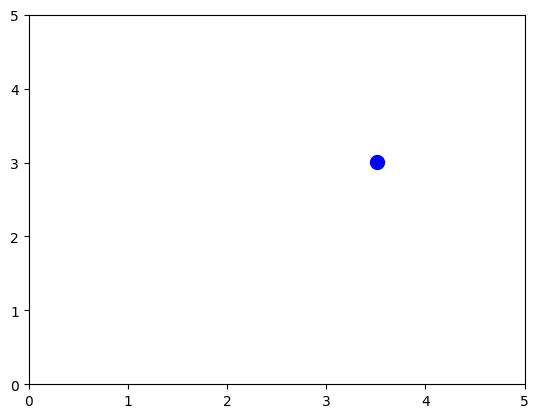

In [24]:
unit = Unit((3, 3), health=100, attack_power=10, attack_speed=1, speed = 0, attack_range = 0)

# Move the unit
for i in range(10):
    unit.move()



# Display animation
unit.plot_position_history()


In [ ]:
class resourceNode:
    def __init__(self, position, max_resources):
        self.position = position
        self.max_resources = max_resources
        self.current_resources = max_resources

    def deplete(self, amount):
        self.current_resources -= amount
        if self.current_resources < 0:
            self.current_resources = 0

In [ ]:
class Swarm:
    def __init__(self, max_units):
        self.max_units = max_units
        self.units = []

    def populate_swarm(self, unit):
        dummy = 0
        #populate swarm and initialize random stats for each unit

    def move(self):
        # Implement movement logic for the entire swarm by working through array
        pass

    def gather_resources(self, resource_nodes):
        # Implement resource gathering logic for the entire swarm by working through array
        pass

    def update(self):
        # Implement any other updates for the swarm i cant think of anything but here is extra stuff
        pass  


In [ ]:
class Battlefield:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.resource_nodes = []
        self.swarms = []

    def populate_resources(self, node):
        dummy = 0
        # populate the resources across the search space

    def create_teams(self, swarm):
        dummy = 0
        #create two swarm by calling swarm

    def simulate(self, num_iterations):
        for _ in range(num_iterations):
            # Update each swarm
            for swarm in self.swarms:
                swarm.move()
                swarm.gather_resources(self.resource_nodes)
                swarm.update()
            #just keep track of the position history and the history of each unit
            # Visualization code (optional) 
            self.visualize()

    def visualize(self):
        # Visualization code to plot the battlefield, units, and resource nodes
        pass

In [ ]:
def main():
    dummy = 0

In [ ]:
if __name__ == "__main__":
    main()